# PROJECT: Course Optimization for Data Science
## Optimization strategies for robust regression


Author: Alexandre Gramfort, Rémi Flamary

If you have questions or if something is not clear in the text below please contact us
by email.

## Aim:

- Formulate the Mean Absolute Error (MAE) regression model as a Quadratic Program
- Derive mathematically and implement the loss and gradients of the Huber model
- Implement your own solvers for L1 or squared L2 regularization with: (Accelerated) Proximal gradient descent, Proximal coordinate descent and L-BFGS (only for L2).
- Implement your own scikit-learn estimator for the Huber model and test it against the Ridge and Lasso from scikit-learn on some real data.
- You are expected to provide clear figures as one could expect from an experiment section in a research paper.


## VERY IMPORTANT

This work must be done by pairs of students.
Each student must send their work before the 31st of January at 23:59, using the moodle platform.
This means that **each student in the pair sends the same file**

On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called "Project".
This is where you submit your jupyter notebook file.

The name of the file must be constructed as in the next cell

### Gentle reminder: no evaluation if you don't respect this EXACTLY

#### How to construct the name of your file

In [58]:
# Change here using YOUR first and last names
fn1 = "solal"
ln1 = "danan"
fn2 = "gregoire"
ln2 = "mourre"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["project", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

project_danan_solal_and_mourre_gregoire.ipynb


Some imports (install cvxopt if not already done so `!pip install cvxopt`):

In [59]:
%matplotlib inline
import numpy as np
from scipy import linalg
import time
import matplotlib.pyplot as plt
import cvxopt

## Part 0: Why a robust regression model


Let us consider the problem of regression from $n$ observations
$x_i \in \mathbb{R}^{p}$,
$1 \leq i \leq n$. We aim to learn a function:
$$f: x \in \mathbb{R}^{p}\mapsto y\in\mathbb{R}$$
from the $n$ annotated training samples $(x_{i},y_{i})$ supposed i.i.d. from an unknown probability distribution on $\mathbb{R}^p \times \mathbb{R}$. Once this function is learnt, it will be possible to use it to predict the label $y$ associated to a new sample $x$.

The types of model we consider in this project are so-called *robust models* that can deal with samples corrupted by strong artifacts.

Let's generate such a dataset in 1D to illustrate the problem when using the squared loss ($\|\cdot\|^2$).

Time for LinearRegression: 0.001s


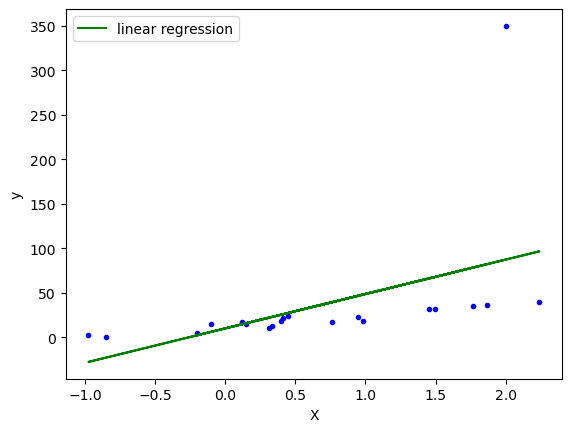

In [60]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression

# Generate toy data
X, y = make_regression(n_samples=20, n_features=1, random_state=0,
                       noise=4.0, bias=10.0)

# Add an outlier
X[0, 0] = 2.
y[0] = 350

# Fit the model
t0 = time.perf_counter()
reg = LinearRegression()
reg.fit(X, y)
print(f"Time for LinearRegression: {time.perf_counter() - t0:.3f}s")

# Visualize the model
x = X[:, 0]
y_pred = reg.coef_ * x + reg.intercept_

plt.plot(x, y, 'b.')
plt.plot(x, y_pred, 'g-', label="linear regression")
plt.xlabel("X")
plt.ylabel("y")
plt.legend(loc=0)
plt.show()

<div class="alert alert-success">
    <b>QUESTION 0:</b>
     <ul>
       <li>Describe the issue you observe and suggest an explanation and a possible solution.</li>
    </ul>
</div>

Linear regression minimizes the sum of squared residuals (errors). The large residual associated with the target outlier has a disproportionately high impact because squaring the residual magnifies the effect of extreme values. This causes the regression line to be pulled toward the outlier

To address this, Mean Absolute error regressiopn or Huber Regression can be used. Huber Regression minimizes a loss function that transitions from quadratic (like OLS) to linear for points with large residuals, reducing the influence of outliers.

## Part 1 : Mean Absolute Error regression

The Mean Absolute Error (MAE) regression model reads:

$$
\min_{w \in \mathbb{R}^p} \frac{1}{n} \sum_{i=1}^n \left|y_i - \langle w, x_i
\rangle-b \right| + \lambda \frac{1}{2}\|w\|_2^2
$$

where $\lambda > 0$ is the regularization parameter for quadratic
regularization.

<div class="alert alert-success">
    <b>QUESTION 1:</b>
     <ul>
       <li>Reformulate the optimization problem as a standard Quadratic Program of the form :</li></ul>
       
$$ \min_{z \in \mathbb{R}^p} f(w) = \frac{1}{2} z^T Q z + c^T z, \quad \text{ subject to } Gz\leq h \text{ and } Az=b $$
       
       
    
</div>

### Reformulation as a Quadratic Program

We first deal with the **absolute value** in the objective function by introducing auxiliary variables $ \xi_i \geq 0 $. This lets us rewrite the optimization problem as:

$$
\min_{w \in \mathbb{R}^p, b \in \mathbb{R}, \xi \in \mathbb{R}^n} \frac{1}{n} \sum_{i=1}^n \xi_i + \frac{\lambda}{2} \|w\|_2^2,
$$

subject to:

$$
y_i - \langle w, x_i \rangle - b \leq \xi_i, \quad - (y_i - \langle w, x_i \rangle - b) \leq \xi_i, \quad \xi_i \geq 0 \quad \text{for } i = 1, \dots, n.
$$


We define the decision variable $ z $ as:

$$
z = \begin{bmatrix} w \\ b \\ \xi \end{bmatrix},
$$

where $ w \in \mathbb{R}^p $, $ b \in \mathbb{R} $, and $ \xi \in \mathbb{R}^n $. The goal is to rewrite the problem in the form:

$$
\min_{z \in \mathbb{R}^k} f(z) = \frac{1}{2} z^T Q z + c^T z,
$$

subject to:

$$
Gz \leq h \quad \text{and} \quad Az = b.
$$


The objective function becomes: $f(z) = \frac{\lambda}{2} \|w\|_2^2 + \frac{1}{n} \sum_{i=1}^n \xi_i. $

This can be written in matrix form as:   $f(z) = \frac{1}{2} z^T Q z + c^T z,$

where:

$$
Q = \begin{bmatrix} \lambda I_p & 0 & 0 \\ 0 & 0 & 0 \\ 0 & 0 & 0 \end{bmatrix},
$$

$ I_p $ is the $ p \times p $ identity matrix, and the zeros correspond to the absence of quadratic terms for $ b $ and $ \xi $.

$$
c = \begin{bmatrix} 0 \\ 0 \\ \frac{1}{n} \mathbf{1}_n \end{bmatrix},
$$

where $ \mathbf{1}_n $ is an $ n $-dimensional column vector of ones.




The constraints are:

$$
y_i - \langle w, x_i \rangle - b \leq \xi_i,
$$

$$
- (y_i - \langle w, x_i \rangle - b) \leq \xi_i,
$$

$$
\xi_i \geq 0.
$$

These can be written in matrix form as $ Gz \leq h $, where:

$$
G = \begin{bmatrix} -X & -\mathbf{1}_n & I_n \\ X & \mathbf{1}_n & I_n \\ 0 & 0 & -I_n \end{bmatrix},
$$

- $ X $ is the $ n \times p $ matrix where each row is $ x_i^T $,
- $ \mathbf{1}_n $ is an $ n $-dimensional column vector of ones,
- $ I_n $ is the $ n \times n $ identity matrix.

$$
h = \begin{bmatrix} y \\ -y \\ 0 \end{bmatrix},
$$

where $ y $ is the $ n $-dimensional vector of $ y_i $'s.

#### Final Quadratic Program

Therefore the optimization problem becomes:

$$
\min_{z \in \mathbb{R}^{p + n + 1}} \frac{1}{2} z^T Q z + c^T z,
$$

subject to:

$$
Gz \leq h.
$$



<div class="alert alert-success">
    <b>QUESTION 2:</b>
     <ul>
       <li>Code the solver for the regularized MAE using the QP solver from `cvxopt` (see example <a href="https://cvxopt.org/examples/tutorial/qp.html">here</a>) or another open source QP solver of your choice. Note that for cvxopt`, numpy array have to be converted to cvxopt `matrix`.</li></ul>          
</div>

In [62]:
from cvxopt import matrix, solvers


def solve_reg_mae(X, y, reg=0):
    n_samples, n_features = X.shape

    # Construct Q
    Q = np.zeros((n_features + 1 + n_samples, n_features + 1 + n_samples))
    Q[:n_features, :n_features] = 2 * reg * np.eye(n_features)

    # Construct c
    c = np.zeros(n_features + 1 + n_samples)
    c[n_features + 1:] = 1.0 / n_samples

    # G and h
    G = np.zeros((2 * n_samples + n_samples, n_features + 1 + n_samples))
    h = np.zeros(2 * n_samples + n_samples)

    # First n_samples rows
    G[:n_samples, :n_features] = -X
    G[:n_samples, n_features] = -1.0
    G[:n_samples, n_features + 1:] = -np.eye(n_samples)
    h[:n_samples] = -y

    # Next n_samples rows
    G[n_samples:2*n_samples, :n_features] = X
    G[n_samples:2*n_samples, n_features] = 1.0
    G[n_samples:2*n_samples, n_features + 1:] = -np.eye(n_samples)
    h[n_samples:2*n_samples] = y

    # Last n_samples rows
    G[2*n_samples:, n_features + 1:] = -np.eye(n_samples)
    h[2*n_samples:] = 0.0

    # Solve the quadratic program
    sol = solvers.qp(matrix(Q), matrix(c), matrix(G), matrix(h))
    
    # Recover w and b from the solution
    w = np.array(sol['x'])[:n_features, 0]
    b = np.array(sol['x'])[n_features]
    return w, b


<div class="alert alert-success">
    <b>QUESTION 3:</b>
     <ul>
       <li>
       
    
    
    
Apply the solver on the toy data and compare it to the previous LinearRegression solution with $\lambda=0.1$.
       
  </li></ul>    
     <ul> <li>Discuss the robustness of MAE VS LS.</li></ul>       
          <ul> <li>Discuss the computational time of MAE QP solver. What is the number of variable to optimize? How well will it scale  to large datasets?</li></ul>       

</div>

     pcost       dcost       gap    pres   dres
 0:  1.4744e+02  1.6553e+05  4e+06  4e+00  4e+03
 1:  4.0460e+02 -4.5314e+04  5e+04  5e-02  4e+01
 2:  2.8878e+02 -2.4865e+03  3e+03  3e-03  2e+00
 3:  2.2550e+02  7.4009e+00  2e+02  1e-05  1e-02
 4:  2.8987e+01  1.9784e+01  9e+00  6e-07  5e-04
 5:  2.5123e+01  2.2572e+01  3e+00  1e-07  1e-04
 6:  2.4388e+01  2.3656e+01  7e-01  2e-08  2e-05
 7:  2.4081e+01  2.3971e+01  1e-01  2e-09  2e-06
 8:  2.4041e+01  2.4031e+01  1e-02  2e-11  2e-08
 9:  2.4037e+01  2.4037e+01  1e-04  2e-13  2e-10
10:  2.4037e+01  2.4037e+01  1e-06  2e-15  2e-12
Optimal solution found.
Time for MAE QP solver: 0.035s


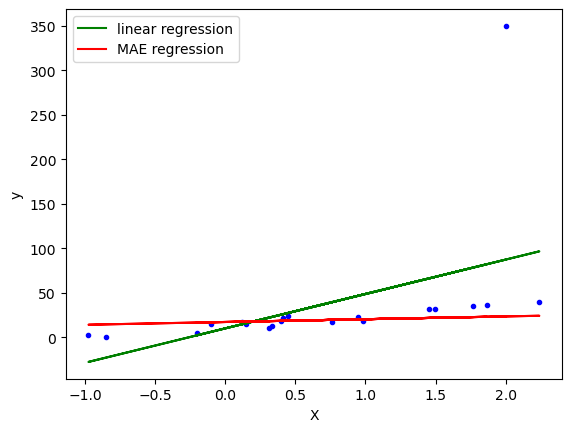

In [63]:
t0 = time.perf_counter()
w_mae, b_mae = solve_reg_mae(X,y,reg=0.1)
print(f"Time for MAE QP solver: {time.perf_counter() - t0:.3f}s")

ypred_mae = X.dot(w_mae)+b_mae

plt.plot(x, y, 'b.')
plt.plot(x, y_pred, 'g-', label="linear regression")
plt.plot(x, ypred_mae, 'r-', label="MAE regression")
plt.xlabel("X")
plt.ylabel("y")
plt.legend(loc=0)
plt.show()


The graph compares the Linear Regression (green) and MAE Regression (red) fits. The Linear Regression is heavily influenced by the outlier, resulting in a skewed slope. In contrast, the MAE Regression is more robust to the outlier, producing a nearly flat line that better represents the majority of the data.

The computational time for the MAE QP solver (0.060s) is significantly slower than Linear Regression (0.010s) due to the complexity of solving a quadratic program (QP). The number of variables to optimize in MAE is p+n+1, where p is the number of features, n is the number of data points, and the additional variable accounts for the bias term. MAE does not scale well to large datasets because the QP solver's complexity grows with the size of the dataset, making it computationally expensive for high n.

## Part 2: Huber Loss

One version of the Huber function ($H_\epsilon : \mathbb{R} \rightarrow \mathbb{R}$) reads:

$$
    H_\epsilon (x) = \left\{
	\begin{aligned}
	x^2 & \quad \mathrm{ if } \quad |x| < \epsilon \\
    2 \epsilon |x| - \epsilon^2 & \quad \mathrm{ otherwise }
	\end{aligned}
    \right.
$$

Working in a regression setting, the Huber loss between 2 targets $y$ and $y'$ reads:

$$
    \mathcal{L}(y, y') = H_\epsilon (y - y')
$$

Here is an implemention of the Huber function:

In [64]:
epsilon = 1.

def huber(x, epsilon=epsilon):
    mask = np.abs(x) < epsilon
    z = x.copy()
    z[mask] = x[mask] ** 2
    z[~mask] = 2 * epsilon * np.abs(x[~mask]) - epsilon ** 2
    return z

<div class="alert alert-success">
    <b>QUESTION 4:</b>
     <ul>
       <li>
       
       
Plot the Huber function vs. the squared function ($x \rightarrow x^2$) vs. the absolute value function ($x \rightarrow |x|$) between -3 and 3 using $\epsilon = 1$</li>
    </ul>
</div>

INSERT YOUR ANSWER HERE

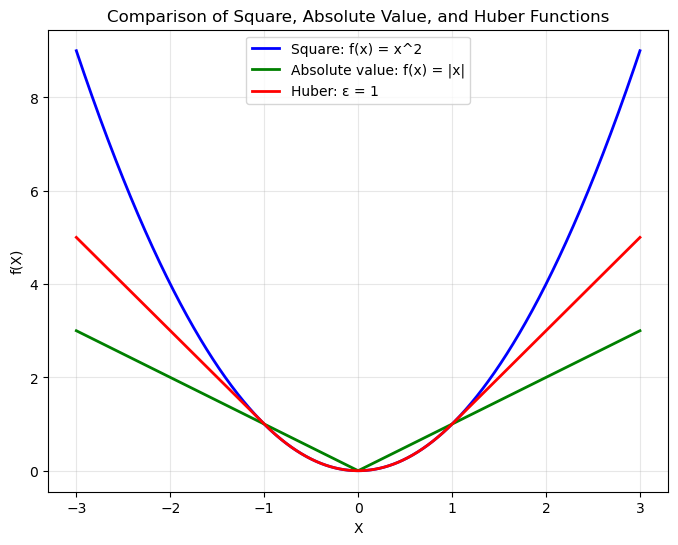

In [65]:
epsilon = 1.0
x = np.linspace(-3, 3, 1000)

plt.figure(figsize=(8, 6))
plt.plot(x, x**2, label='Square: f(x) = x^2', color='blue', linewidth=2)
plt.plot(x, np.abs(x), label='Absolute value: f(x) = |x|', color='green', linestyle='-', linewidth=2)
plt.plot(x, huber(x, epsilon), label='Huber: ε = 1', color='red', linestyle='-', linewidth=2)
plt.xlabel("X")
plt.ylabel("f(X)")
plt.title("Comparison of Square, Absolute Value, and Huber Functions")
plt.legend(loc='upper center')
plt.grid(alpha=0.3)
plt.show()

<div class="alert alert-success">
    <b>QUESTION 5:</b>
     <ul>
       <li>Justify the convexity of the Huber function as defined above.</li>
       <li>Justify the smoothness of the Huber function as defined above and propose a value of for the Lipschitz constant of its gradient.</li>
    </ul>
</div>

The Huber function $ H_\epsilon(x) $ is convex because:

- **For $ |x| < \epsilon $:**  
   In this region, $ H_\epsilon(x) = x^2 $, which is a quadratic function.  
   - The second derivative of $ H_\epsilon(x) $ is: $\frac{d^2}{dx^2} H_\epsilon(x) = 2 > 0,$ which indicates that $ H_\epsilon(x) $ is strictly convex.

- **For $ |x| > \epsilon $:**  
   In this region, $ H_\epsilon(x) = 2\epsilon |x| - \epsilon^2 $.  
   - The absolute value function $ |x| $ is convex, and multiplying a convex function by a positive scalar ($ 2\epsilon $) preserves convexity.
   - Adding or subtracting a constant ($ -\epsilon^2 $) does not affect convexity.
   Therefore, $ H_\epsilon(x) $ is convex in this region as well.

- **At the transition point $ |x| = \epsilon $:**  
   - **Continuity of $ H_\epsilon(x) $:**  
     The two pieces of the function meet : $H_\epsilon(\epsilon) = \epsilon^2, \quad H_\epsilon(-\epsilon) = \epsilon^2.$
     Thus, $ H_\epsilon(x) $ is continuous at $ x = \pm \epsilon $.

   - **Continuity of the gradient $ \nabla H_\epsilon(x) $:**  
     The gradient of $ H_\epsilon(x) $ is:
     $
     \nabla H_\epsilon(x) =
     \begin{cases}
     2x & \text{if } |x| < \epsilon, \\
     2\epsilon \cdot \text{sign}(x) & \text{if } |x| \geq \epsilon.
     \end{cases}
     $

     At $ x = \epsilon $:
     - From the left ($ |x| < \epsilon $): $ \nabla H_\epsilon(x) = 2\epsilon $.
     - From the right ($ |x| \geq \epsilon $): $ \nabla H_\epsilon(x) = 2\epsilon $.
     Since the gradient matches at $ x = \epsilon $, the function is continuously differentiable.

A function that is convex in two regions and has continuous gradients at the transition points is globally convex.




### Justify smoothness

<div class="alert alert-success">
    <b>QUESTION 6:</b>
     <ul>
       <li>Write a function that computes the gradient of the Huber loss.</li>
    </ul>
</div>

**Remark:** You will use the `scipy.optimize.check_grad` function to assess the validity of your result. You will need to test your gradient in both the linear and quadratic regions of the Huber function (not just in one location).

INSERT YOUR ANSWER HERE

In [66]:
from scipy.optimize import check_grad

epsilon = 1.

def huber_grad(x, epsilon=epsilon):
    mask = np.abs(x) < epsilon
    z = x.copy()
    z[mask] = 2* x[mask]
    z[~mask] = 2 * epsilon * np.sign(x[~mask])
    return z

x0 = np.linspace(-2, 4, 7)
gradient_check = [check_grad(huber, huber_grad, x) for x in x0]
print(gradient_check)

[0.0, 1.4901161193847656e-08, 1.4901161193847656e-08, 0.0, 0.0, 0.0, 0.0]


The gradient check confirms that the implementation of huber_grad is correct, with near-zero differences indicating numerical consistency.

Let us define the cost function associated to the empirical risk with some regularization function $\mathcal{R}$:

$$
    (\mathcal{P}_{f,\mathcal{R}}):
	\begin{aligned}
	\min_{w \in \mathbb{R}^p, b \in \mathbb{R}} \quad \frac{1}{n} \sum_{i=1}^n f(y_i - x_i^\top w - b) + \lambda \mathcal{R}(w) \enspace ,
	\end{aligned}
$$

where $f$ is a scalar function defining the loss (Huber, squared, absolute etc.). The variable $b$ is the bias or intercept term.

<div class="alert alert-success">
    <b>QUESTION 7:</b>
     <ul>
      <li>
      
      
  Let us consider for $\mathcal{R}$ either the $\ell_1$ norm ($\mathcal{R}_1(w) = \|w\|_1 = \sum_{j=1}^p |w_j|$) or the squared $\ell_2$ norm ($\mathcal{R}_2(w) = \|w\|_2^2 = \sum_{j=1}^p w_j^2)$. Justify what optimization strategy among L-BFGS, (proximal-)gradient descent, (proximal-)coordinate descent is readily applicable, depending on the choice of $\mathcal{R}$ when $f$ is the Huber function as defined above.</li>
    </ul>
</div>

INSERT YOUR ANSWER HERE

<div class="alert alert-success">
    <b>QUESTION 8:</b>
    <ul>
    <li>
        
        
Taking as $f$ the Huber function and the $\mathcal{R}_2$ regularization function, solve the optimization prolem $(\mathcal{P}_{H_\epsilon,\mathcal{R}_2})$ using the `fmin_l_bfgs_b` function from `scipy.optimize`. You are expected to provide the explicit gradient (fprime parameter) to `fmin_l_bfgs_b`.
    </li>
    <li>Using the simulated dataset from above, you will check that your solver fixes the problem of the outlier provided that $\lambda$ is small enough (eg. $\lambda = 0.01$). Your are expected to make a plot of the regression fit.</li>
    </ul>
</div>

The estimate of $w$ and $b$ should be called `w_hat` and `b_hat`. You will call the regularization parameter $\lambda$ as `lbda` in the code.

To help you we provide you with the function `pobj_l2` that computes the primal objective to minimize. Note that the parameters `w` and `b` are combined in a single array `params`.

Time for Huber solver: 0.003s


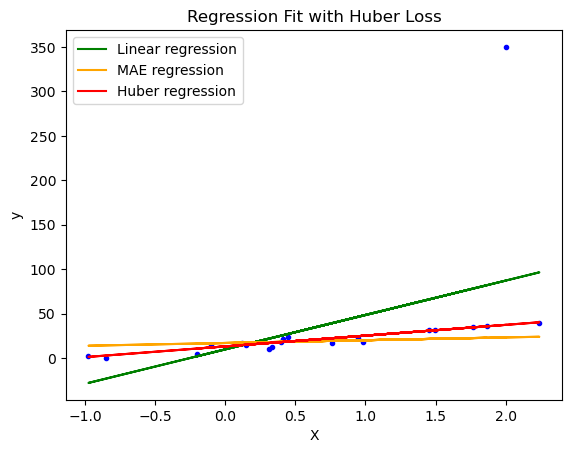

In [67]:
from scipy.optimize import fmin_l_bfgs_b

lbda = 0.01
epsilon = 1.


def pobj_l2(params, X=X, y=y, lbda=lbda, epsilon=epsilon):
    w = params[1:]
    b = params[0]
    return np.mean(huber(y - np.dot(X, w) - b, epsilon=epsilon)) + lbda * np.sum(w ** 2)

def pobj_grad_l2(params, X, y, lbda, epsilon=epsilon):
    w = params[1:]
    b = params[0]    
    huber_grad_residuals = huber_grad(y - np.dot(X, w) - b, epsilon=epsilon)
    
    grad_b = -np.mean(huber_grad_residuals)  
    grad_w = -np.dot(X.T, huber_grad_residuals) / X.shape[0] + 2 * lbda * w 
    
    grad = np.concatenate(([grad_b], grad_w))
    return grad


def huber_lbfgs_l2(X=X, y=y, lbda=lbda, epsilon=epsilon):
    n_features = X.shape[1]
    initial_params = np.zeros(n_features + 1)

    params, _, _ = fmin_l_bfgs_b(
        func=pobj_l2,
        x0=initial_params,
        fprime=pobj_grad_l2,
        args=(X, y, lbda, epsilon),
        maxiter=1000
    )
    return params[1:], params[0]

t0 = time.perf_counter()
w_hat, b_hat = huber_lbfgs_l2(X, y, lbda, epsilon)
print(f"Time for Huber solver: {time.perf_counter() - t0:.3f}s")

ypred_hub = X.dot(w_hat)+b_hat
x = X[:, 0]

plt.plot(x, y, 'b.')
plt.plot(x, y_pred, 'g-', label="Linear regression")
plt.plot(x, ypred_mae, 'orange', label="MAE regression")
plt.plot(x, ypred_hub, 'r-', label="Huber regression")
plt.title("Regression Fit with Huber Loss")
plt.xlabel("X")
plt.ylabel("y")
plt.legend(loc=0)
plt.show()
# END TODO

The Huber regression balances robustness to the outlier with smoothness. It ignores the extreme impact of the outlier while fitting the main data trend effectively. The red line closely matches the majority of the data, showing its advantage over MAE and Linear Regression.

## Part 3: Huber Loss with L1 regularization

In this section we are interested in the $\ell_1$ regularized model.
To help you we give you the code of the objective function to minimize.

In [56]:
def pobj_l1(params, X=X, y=y, lbda=lbda, epsilon=epsilon):
    w = params[1:]
    b = params[0]
    return np.mean(huber(y - np.dot(X, w) - b, epsilon=epsilon)) + lbda * np.sum(np.abs(w))

Now that we have the cost function, you are going to implement solvers based on:

- Proximal Gradient Descent (PGD aka ISTA)
- Accelerated Proximal Gradient Descent (APGD aka FISTA)
- Proximal Coordinate Descent (PCD)

Before this we are going to define the `monitor` class previously used in the second lab as well as plotting functions useful to monitor convergence.

In [57]:
class monitor(object):
    def __init__(self, algo, obj, x_min, args=()):
        self.x_min = x_min
        self.algo = algo
        self.obj = obj
        self.args = args
        if self.x_min is not None:
            self.f_min = obj(x_min, *args)

    def run(self, *algo_args, **algo_kwargs):
        t0 = time.time()
        _, x_list = self.algo(*algo_args, **algo_kwargs)
        self.total_time = time.time() - t0
        self.x_list = x_list
        if self.x_min is not None:
            self.err = [linalg.norm(x - self.x_min) for x in x_list]
            self.obj = [self.obj(x, *self.args) - self.f_min for x in x_list]
        else:
            self.obj = [self.obj(x, *self.args) for x in x_list]


def plot_epochs(monitors, solvers):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    for monit in monitors:
        ax1.semilogy(monit.obj, lw=2)
        ax1.set_title("Objective")
        ax1.set_xlabel("Epoch")
        if monit.x_min is None:
            ax1.set_ylabel("$f(x_k)$")
        else:
            ax1.set_ylabel("$f(x_k) - f(x^*)$")

    ax1.legend(solvers)

    for monit in monitors:
        if monit.x_min is not None:
            ax2.semilogy(monit.err, lw=2)
            ax2.set_title("Distance to optimum")
            ax2.set_xlabel("Epoch")
            ax2.set_ylabel("$\|x_k - x^*\|_2$")

    ax2.legend(solvers)


def plot_time(monitors, solvers):
    for monit in monitors:
        objs = monit.obj
        plt.semilogy(np.linspace(0, monit.total_time, len(objs)), objs, lw=2)
        plt.title("Loss")
        plt.xlabel("Timing")
        plt.ylabel("$f(x_k) - f(x^*)$")

    plt.legend(solvers)

<div class="alert alert-success">
    <b>QUESTION 9a:</b>
    <ul>
    <li>
        Implement the proximal gradient descent (PGD) method.
    </li>
    </ul>
</div>

**Note:**  The parameter `step` is the size of the gradient step that you will need to propose by computing the Lipschitz constant of the data fitting term (Huber term without regularization term).

In [ ]:
def pgd(x_init, grad, prox, step, n_iter=100, store_every=1,
        grad_args=(), prox_args=()):
    """Proximal gradient descent algorithm.
    
    Parameters
    ----------
    x_init : array, shape (n_parameters,)
        Parameters of the optimization problem.
    grad : callable
        The gradient of the smooth data fitting term.
    prox : callable
        The proximal operator of the regularization term.
    step : float
        The size of the gradient step done on the smooth term.
    n_iter : int
        The number of iterations.
    store_every : int
        At which frequency should the current iterated be remembered.
    grad_args : tuple
        Parameters to pass to grad.
    prox_args : tuple
        Parameters to pass to prox.
    
    Returns
    -------
    x : array, shape (n_parameters,)
        The estimated parameters.
    x_list : list
        The list if x values along the iterations.
    """
    x = x_init.copy()
    x_list = []
    for i in range(n_iter):
        ### TODO

        ### END TODO
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

<div class="alert alert-success">
    <b>QUESTION 9b:</b>
    <ul>
    <li>
        Implement the L1 and L2 proximal operators. You will pay attention to the intercept.
    </li>
    <li>
        Using the monitor class and the plot_epochs function, display the convergence.
    </li>
    </ul>
</div>

In order to get a good value of `x_min` you will let your PGD solver run for 10000 iterations.

First you will need to implement the proximal operator functions for $\ell_1$ and $\ell_2$ regularized models.

In [ ]:
def prox_R2(params, reg=1.):
    # TODO

    # END TODO
    return params


def prox_R1(params, reg=1.):
    # TODO

    # END TODO
    return params


def prox_l2(params, step, lbda):
    return prox_R2(params, reg=step * lbda)


def prox_l1(params, step, lbda):
    return prox_R1(params, reg=step * lbda)

In [ ]:
# Generate bigger data
X, y = make_regression(n_samples=500, n_features=100, random_state=0,
                       noise=4.0, bias=10.0)
n_samples, n_features = X.shape

# Set initial values of parameters to optimize
x_init = np.zeros(n_features + 1)
x_init[0] = np.mean(y)
n_iter = 2000
lbda = 1.
epsilon = 1.

# TODO

# END TODO

# Run PGD
monitor_pgd_l2 = monitor(pgd, pobj_l2, x_min, args=(X, y, lbda, epsilon))
monitor_pgd_l2.run(x_init, grad_huber_loss, prox_l2, step, n_iter,
                   grad_args=(X, y, epsilon), prox_args=(lbda,))

monitors = [monitor_pgd_l2]
solvers = ["PGD"]
plot_epochs(monitors, solvers)

Now for the $\ell_1$ regularization:

In [ ]:
# Run PGD for L1
monitor_pgd_l1 = monitor(pgd, pobj_l1, x_min=None, args=(X, y, lbda, epsilon))
monitor_pgd_l1.run(x_init, grad_huber_loss, prox_l1, step, n_iter,
                   grad_args=(X, y, epsilon), prox_args=(lbda,))

monitors = [monitor_pgd_l1]
solvers = ["PGD"]
plot_epochs(monitors, solvers)

<div class="alert alert-success">
    <b>QUESTION 10:</b>
    <ul>
    <li>
        Implement the accelerated proximal gradient descent (APGD) and add this solver to the monitoring plots.
    </li>
    </ul>
</div>

In [ ]:
def apgd(x_init, grad, prox, step, n_iter=100, store_every=1,
         grad_args=(), prox_args=()):
    """Accelerated proximal gradient descent algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    t = 1.
    x_list = []
    for i in range(n_iter):
        ### TODO

        ### END TODO
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [ ]:
# TODO

# END TODO

monitors = [monitor_pgd_l2, monitor_apgd_l2]
solvers = ["PGD", "APGD"]
plot_epochs(monitors, solvers)

In [ ]:
# TODO

# END TODO

monitors = [monitor_pgd_l1, monitor_apgd_l1]
solvers = ["PGD", "APGD"]
plot_epochs(monitors, solvers)

<div class="alert alert-success">
    <b>QUESTION 11:</b>
    <ul>
    <li>
        Implement the proximal coordinate descent (PCD) and add this solver to the monitoring plots for L1 and L2 regularized models.
    </li>
    </ul>
</div>

**Note:** You are welcome to try to use numba to get reasonable performance but don't spend too much time if you get weird numba errors.

In [ ]:
# TODO

# END TODO

<div class="alert alert-success">
    <b>QUESTION 12:</b>
    <ul>
    <li>
        Compare the performance of the different solvers for different (simulated) problem sizes.
    </li>
    <li>
        What solver would you recommend for what problem and using what regularization?
    </li>
    </ul>
</div>

YOUR ANSWER HERE

## Part 4: Application

You will now apply your solver to an environment dataset. Given 2 features:

 - LNOxEm log of hourly sum of NOx emission of cars on this motorway in arbitrary units.
 - sqrtWS Square root of wind speed [m/s].

The objective is to predict:

 - log of hourly mean of NOx concentration in ambient air [ppb] next to a highly frequented motorway

**Disclaimer:** This dataset is not huge and regularization makes little sense with so little features but it serves as a simple illustration. Also, don't be surprised if Huber loss offers little to no benefit. Again it's just an illustration.

Let's first inspect the dataset:

In [ ]:
import pandas as pd

df = pd.read_csv('NOxEmissions.csv', index_col=0).drop(['julday'], axis=1)
df.head()

Now let's extract `X` and `y`

In [ ]:
X = df.loc[:, ['LNOxEm', 'sqrtWS']].values
y = df['LNOx']
X.shape, y.shape

In [ ]:
plt.scatter(X[:, 1], y);

In order to facilitate our experiment we're going to write a full scikit-learn estimator.

<div class="alert alert-success">
    <b>QUESTION 13:</b>
    <ul>
    <li>
        Implement the `fit` method from the estimator in the next cell
    </li>
    </ul>
</div>

In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin


class HuberRegressor(BaseEstimator, RegressorMixin):
    """scikit-learn estimator for regression with a Huber loss
    
    Parameters
    ----------
    lbda : float
        The regularization parameter
    penalty : 'l1' | 'l2'
        The type of regularization to use.
    max_iter : int
        The number of iterations / epochs to do on the data.
    solver : 'pgd' | 'apgd' | 'pcd'
        The type of algorithm to use.
        
    Attributes
    ----------
    coef_ : ndarray, (n_features,)
        The weitghs w.
    intercept_ : float
        The intercept or bias term b.
    """
    def __init__(self, lbda=1., penalty='l2', epsilon=1.,
                 max_iter=2000, solver='pgd'):
        self.lbda = lbda
        self.penalty = penalty
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.solver = solver
        assert epsilon > 0.
        assert self.penalty in ['l1', 'l2']
        assert self.solver in ['pgd', 'apgd', 'pcd'] 

    def fit(self, X, y):
        """Fit method
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.
        y : ndarray, shape (n_samples,)
            The target.
        """
        n_samples, n_features = X.shape
        # TODO

        # END TODO
        self.params_ = x
        self.coef_ = x[1:]
        self.intercept_ = x[0]
        return self

    def predict(self, X):
        """Predict method
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.

        Returns
        -------
        y_pred : ndarray, shape (n_samples,)
            The predicted target.
        """
        return np.dot(X, self.coef_) + self.intercept_

    
    def score(self, X, y):
        """Score using negative mean absolute error
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.
        y : ndarray, shape (n_samples,)
            The target.
            
        Returns
        -------
        score : float
            The negative mean absolute error.
            Negative to keep the semantic that higher is better.
        """
        return -np.mean(np.abs(y - self.predict(X)))


for solver in ['pgd', 'apgd', 'pcd']:
    clf = HuberRegressor(lbda=1., penalty='l2', max_iter=1000, solver=solver)
    clf.fit(X, y)
    print('Solver with L2: %s   \t-   MAE : %.5f' % (solver, -clf.score(X, y)))

for solver in ['pgd', 'apgd', 'pcd']:
    clf = HuberRegressor(lbda=1., penalty='l1', max_iter=1000, solver=solver)
    clf.fit(X, y)
    print('Solver with L1: %s   \t-   MAE : %.5f' % (solver, -clf.score(X, y)))

<div class="alert alert-success">
    <b>QUESTION 14:</b>
    <ul>
        <li>
            Compare the cross-validation performance of your model (using `cross_val_score`) with a Ridge or Lasso regression models using as scoring metric the "mean absolute error" (MAE).
        </li>
        <li>
            You will check that the Huber model matches Ridge when epsilon is large. Pay attention to how the loss is scaled in scikit-learn for Ridge (no normalization by 1/n_samples).
        </li>
        <li>
            You will comment on the running time of your solver to reach their optimal prediction performance.
        </li>
    </ul>
</div>

To score your model with MAE using cross_val_score you need to pass as parameter `scoring='neg_mean_absolute_error'`.

In [ ]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score

# TODO

# END TODO